In [1]:
%matplotlib_svg
import pylab as pl
import numpy as np
from scipy import signal

### 信号处理-signal

### 中值滤波

True


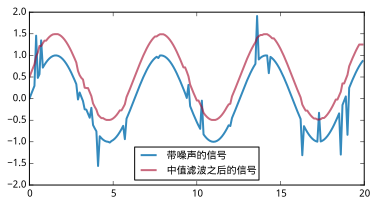

In [5]:
#%fig=使用中值滤波剔除瞬间噪声
t = np.arange(0, 20, 0.1)
x = np.sin(t)
x[np.random.randint(0, len(t), 20)] += np.random.standard_normal(20)*0.6 #❶
x2 = signal.medfilt(x, 5) #❷
x3 = signal.order_filter(x, np.ones(5), 2)
print np.all(x2 == x3)
pl.plot(t, x, label=u"带噪声的信号")
pl.plot(t, x2 + 0.5, alpha=0.6, label=u"中值滤波之后的信号")
pl.legend(loc="best");

### 滤波器设计

In [5]:
sampling_rate = 8000.0

# 设计一个带通滤波器：
# 通带为0.2*4000 - 0.5*4000
# 阻带为<0.1*4000, >0.6*4000
# 通带增益的最大衰减值为2dB
# 阻带的最小衰减值为40dB
b, a = signal.iirdesign([0.2, 0.5], [0.1, 0.6], 2, 40) #❶

# 使用freq计算滤波器的频率响应
w, h = signal.freqz(b, a) #❷

# 计算增益
power = 20*np.log10(np.clip(np.abs(h), 1e-8, 1e100)) #❸
freq = w / np.pi * sampling_rate / 2

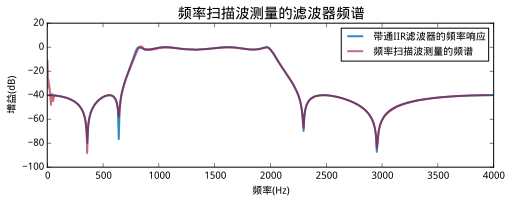

In [6]:
#%fig=用频率扫描波测量的频率响应
# 产生2秒钟的取样频率为sampling_rate Hz的频率扫描信号
# 开始频率为0， 结束频率为sampling_rate/2
t = np.arange(0, 2, 1/sampling_rate) #❶
sweep = signal.chirp(t, f0=0, t1=2, f1=sampling_rate/2) #❷
# 对频率扫描信号进行滤波
out = signal.lfilter(b, a, sweep) #❸
# 将波形转换为能量
out = 20*np.log10(np.abs(out)) #❹
# 找到所有局部最大值的下标
index = signal.argrelmax(out, order=3)  #❺
# 绘制滤波之后的波形的增益
pl.figure(figsize=(8, 2.5))
pl.plot(freq, power, label=u"带通IIR滤波器的频率响应") 
pl.plot(t[index]/2.0*4000, out[index], label=u"频率扫描波测量的频谱", alpha=0.6) #❻
pl.legend(loc="best")
#%hide
pl.title(u"频率扫描波测量的滤波器频谱")
pl.ylim(-100,20)
pl.ylabel(u"增益(dB)")
pl.xlabel(u"频率(Hz)");

### 连续时间线性系统

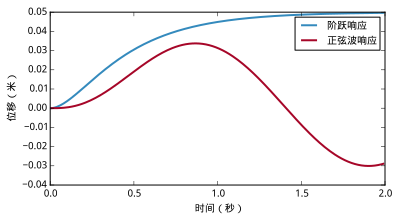

In [9]:
#%fig=系统的阶跃响应和正弦波响应
m, b, k = 1.0, 10, 20

numerator = [1]
denominator = [m, b, k]

plant = signal.lti(numerator, denominator) #❶

t = np.arange(0, 2, 0.01)
_, x_step = plant.step(T=t) #❷
_, x_sin, _ = signal.lsim(plant, U=np.sin(np.pi*t), T=t) #❸
#%hide
pl.plot(t, x_step, label=u"阶跃响应")
pl.plot(t, x_sin, label=u"正弦波响应")
pl.legend(loc="best")
pl.xlabel(u"时间（秒）")
pl.ylabel(u"位移（米）");

In [10]:
from numbers import Real

def as_sys(s):
    if isinstance(s, Real):
        return SYS([s], [1])
    return s

class SYS(object):
    def __init__(self, num, den):
        self.num = num
        self.den = den
        
    def feedback(self): #❶
        return self / (self + 1)
        
    def __mul__(self, s):
        s = as_sys(s)
        num = np.polymul(self.num, s.num)
        den = np.polymul(self.den, s.den)
        return SYS(num, den)
    
    def __add__(self, s):
        s = as_sys(s)
        den = np.polymul(self.den, s.den)
        num = np.polyadd(np.polymul(self.num, s.den),
                         np.polymul(s.num, self.den))
        return SYS(num, den)
    
    def __sadd__(self, s):
        return self + s

    def __div__(self, s):
        s = as_sys(s)
        return self * SYS(s.den, s.num)
    
    def __iter__(self): #❷
        return iter((self.num, self.den))    

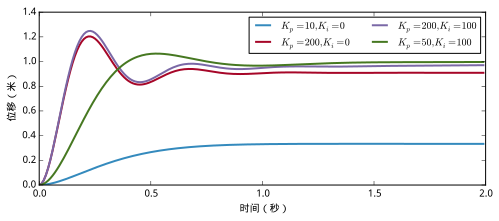

In [27]:
#%fig=使用PI控制器的控制系统的阶跃响应
M, b, k = 1.0, 10, 20
plant = SYS([1], [M, b, k]) #❶

pi_settings = [(10, 1e-10), (200, 1e-10),
               (200, 100),  (50, 100)]

fig, ax = pl.subplots(figsize=(8, 3))

for pi_setting in pi_settings:
    pi_ctrl = SYS(pi_setting, [1, 1e-6]) #❷
    feedback = (pi_ctrl * plant).feedback() #❸
    _, x = signal.step(feedback, T=t)    
    label = "$K_p={:d}, K_i={:3.0f}$".format(*pi_setting)
    ax.plot(t, x, label=label)
    
ax.legend(loc="best", ncol=2)
ax.set_xlabel(u"时间（秒）")
ax.set_ylabel(u"位移（米）");

In [28]:
_, f, _ = signal.lsim(pi_ctrl, U=1-x, T=t)

In [29]:
kd, kp, ki = 30, 200, 400
pid_ctrl = SYS([kd, kp, ki], [1, 1e-6])
feedback = (pid_ctrl * plant).feedback()
_, x2 = signal.step(feedback, T=t)

In [30]:
lp = SYS([1], [0.2, 1])
lp_feedback = lp * (pid_ctrl * plant).feedback()
_, x3 = signal.step(lp_feedback, T=t)

In [31]:
pid_out = (pid_ctrl * lp) / (pid_ctrl * plant + 1)
_, f3 = signal.step(pid_out, T=t)

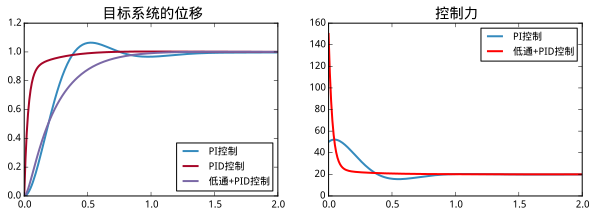

In [33]:
#%figonly=滑块的位移以及控制力
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(10, 3))
ax1.plot(t, x, label=u"PI控制")
ax1.plot(t, x2, label=u"PID控制")
ax1.plot(t, x3, label=u"低通+PID控制")
ax2.plot(t, f, label=u"PI控制")
ax2.plot(t, f3, color="r", label=u"低通+PID控制")
ax1.legend(loc="best")
ax2.legend(loc="best")
ax1.set_title(u"目标系统的位移")
ax2.set_title(u"控制力");